In [92]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [93]:
test = pd.read_csv("llm-detect-ai-generated-text/test_essays.csv")

In [94]:
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [95]:
train= pd.read_csv("llm-detect-ai-generated-text/train_essays.csv")

In [96]:
# 0 for essay written by student, 1 written by AI/LLM
train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [97]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [98]:
train[train['generated']==1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [99]:
train_prompts = pd.read_csv("llm-detect-ai-generated-text/train_prompts.csv")

In [100]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [101]:
#Source of second dataset https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/

In [102]:
#Load the second dataset
second_dataset = pd.read_csv("archive/train_drcat_04.csv")

In [103]:
#1 for AI generated and 0 for student text
second_dataset

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0
...,...,...,...,...,...,...
44201,F7341069C4A4,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,NaN,7
44202,AFE6E553DAC2,I believe that using this technology could be ...,0,persuade_corpus,NaN,8
44203,falcon_180b_v1_600,The Face on Mars is a fascinating phenomenon t...,1,falcon_180b_v1,You have read the article 'Unmasking the Face ...,3
44204,A5F84C104693,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,NaN,1


In [104]:
second_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   essay_id  44206 non-null  object
 1   text      44206 non-null  object
 2   label     44206 non-null  int64 
 3   source    44206 non-null  object
 4   prompt    12911 non-null  object
 5   fold      44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [105]:
second_dataset['label'].value_counts()

label
0    29792
1    14414
Name: count, dtype: int64

In [106]:
second_dataset.duplicated('text').sum()

51

In [107]:
#drop the duplicated rows and keep only the first by default.
second_dataset.drop_duplicates('text',inplace=True)

In [108]:
second_dataset['source'].value_counts()

source
persuade_corpus         25964
mistral7binstruct_v2     2421
mistral7binstruct_v1     2421
chat_gpt_moth            2421
llama2_chat              2421
original_moth            2402
train_essays             1378
llama_70b_v1             1172
falcon_180b_v1           1055
darragh_claude_v7        1000
darragh_claude_v6        1000
radek_500                 500
Name: count, dtype: int64

In [109]:
#1 for AI generated and 0
ai_genereated_text = second_dataset.loc[second_dataset['label']==1][["text","label"]]

In [110]:
#Rename the labels to conform with original dataset
ai_genereated_text = ai_genereated_text.rename(columns={"text":"text","label":"generated"})
ai_genereated_text

,text,generated
0,"In recent years, technology has had a profoun...",1
4,I strongly believe that meditation and mindful...,1
9,One way school administrators can attempt to c...,1
11,While summer is meant as a break from the regu...,1
12,The use of Facial Action Coding System (FACS) ...,1
...,...,...
44190,I think it's a good idea for schools to have o...,1
44195,Students often debate whether inactivity or s...,1
44197,The Seagoing Cowboys program is an amazing opp...,1
44199,Advantages of Limiting Car Usage\n\nLimiting c...,1


In [111]:
human_text = second_dataset.loc[second_dataset['label']==0][["text","label"]]

In [112]:
#human text = 0
#renaming 
human_text = human_text.rename(columns={"text":"text","label":"generated"})
human_text

,text,generated
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
5,"As technology develops more, we need to consid...",0
6,The positive attitude is the key of the succes...,0
...,...,...
44200,Are driverless cars really necessary? Most of ...,0
44201,"""Oh man I didn't make the soccer team!"", yelle...",0
44202,I believe that using this technology could be ...,0
44204,Texting & Driving\n\nUsing your phone while dr...,0


In [113]:
#check from the new dataset and original if common AI text exist
common_text_of_ai = ai_genereated_text['text'].isin(train['text'])
common_text_of_ai.sum()

#all three samples in original data is present in the new data

3

In [114]:
unique_ai_text = ai_genereated_text[~common_text_of_ai]
unique_ai_text.shape

(14411, 2)

In [115]:
common_human_text = human_text['text'].isin(train['text'])
common_human_text.sum()

1375

In [116]:
unique_human_text = human_text[~common_human_text]
unique_human_text.shape

(28366, 2)

In [117]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [118]:
unique_human_text['generated'].value_counts()

generated
0    28366
Name: count, dtype: int64

In [119]:
unique_ai_text['generated'].value_counts()

generated
1    14411
Name: count, dtype: int64

In [120]:
# Merging the two datasets
all_data = pd.concat([train,unique_ai_text,unique_human_text.sample(13039)]) #14414-1375= 13039
all_data = all_data.sample(frac=1).reset_index(drop=True)
all_data

,id,prompt_id,text,generated
0,NaN,NaN,Venus is Earth's sister plant or as other peop...,0
1,NaN,NaN,Adding one and a half extra hours to the schoo...,1
2,NaN,NaN,"Dear, Mr Generic_Name. I am a student who is ...",1
3,NaN,NaN,"Dear Senator,\n\nI am writting to you today to...",1
4,NaN,NaN,I think driverless cars are a great idea. If y...,0
...,...,...,...,...
28823,NaN,NaN,Many schools throughout the world offer distan...,0
28824,NaN,NaN,"Okay, here is my attempt at writing an essay a...",1
28825,NaN,NaN,Would you rather have a very well educated tea...,0
28826,NaN,NaN,Ever wonder what is like if every one stop usi...,0


<Axes: ylabel='count'>

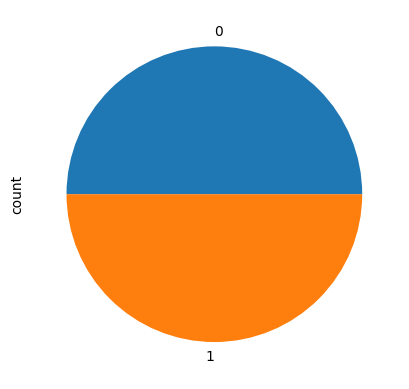

In [121]:
all_data['generated'].value_counts().plot.pie()

In [122]:
all_data['generated'].value_counts()

generated
0    14414
1    14414
Name: count, dtype: int64

## Train and Test Split

In [123]:
X= all_data['text']
y = all_data['generated']

In [124]:
X

0        Venus is Earth's sister plant or as other peop...
1        Adding one and a half extra hours to the schoo...
2         Dear, Mr Generic_Name. I am a student who is ...
3        Dear Senator,\n\nI am writting to you today to...
4        I think driverless cars are a great idea. If y...
                               ...                        
28823    Many schools throughout the world offer distan...
28824    Okay, here is my attempt at writing an essay a...
28825    Would you rather have a very well educated tea...
28826    Ever wonder what is like if every one stop usi...
28827     I strongly agree with Thomas Jefferson's stat...
Name: text, Length: 28828, dtype: object

In [125]:
all_data['generated'].value_counts()

generated
0    14414
1    14414
Name: count, dtype: int64

In [127]:
X_train,X_test_temp,y_train,y_test_temp = train_test_split(X,y,test_size=0.3,random_state=42)

X_val,X_test,y_val,y_test = train_test_split(X_test_temp,y_test_temp,test_size=0.5,random_state=42)

In [128]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(20179,) (20179,)
(4324,) (4324,)
(4325,) (4325,)


In [129]:
y_test.value_counts()

generated
1    2183
0    2142
Name: count, dtype: int64

In [130]:
X_test

12933    Though I do not like summer projects, as I fee...
20514    I think that we should be able to have cell ph...
14929    Cell phones are a big part of our society toda...
11666    Having a positive attitude in life is essentia...
27925    Being an individual is a vital part of having ...
                               ...                        
26609    Participating in the Seagoing Cowboys program ...
12922    "All of our development since World War II has...
26863    Dear Principal,\n\nI feel we should have the f...
24569     I believe that being an active student is the...
16394    Dear, principal\n\nI believe that you should n...
Name: text, Length: 4325, dtype: object

### Data Processing 

In [40]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [132]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+','',text)#remove digits
    text = re.sub(r'[^\w\s]','',text)
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def perform_lemmatization(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lematized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lematized_tokens

def clean_text(text):
    tokens = preprocess_text(text)
    filtered_tokens = remove_stopwords(tokens)
    lemmatized_tokens = perform_lemmatization(filtered_tokens)
    return lemmatized_tokens



In [133]:
sample_cleaned_text = clean_text(train.iloc[0]['text'])
#print(sample_cleaned_text)

In [134]:
#Apply the clean_code function on each set
X_train_cleaned = X_train.apply(clean_text)
X_val_cleaned = X_val.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [135]:
len(X_test_clean)

4325

In [138]:
tokenizer = Tokenizer()

In [139]:
tokenizer.fit_on_texts(X_train_cleaned)

In [140]:
word_index = tokenizer.word_index
total_words = len(word_index)
print(total_words) #same as length of vocabulary

50445


In [141]:
x_train_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
x_val_sequences = tokenizer.texts_to_sequences(X_val_cleaned)

In [142]:
x_test_sequences = tokenizer.texts_to_sequences(X_test_clean)

In [143]:
print('Shape of training tensor: ',len(x_train_sequences))
print('Shape of validating tensor: ', len(x_val_sequences))
print('Shape of testing tensor: ', len(x_test_sequences))

Shape of training tensor:  20179
Shape of validating tensor:  4324
Shape of testing tensor:  4325


In [144]:
max_length =max([len(w) for w in x_train_sequences])
print(max_length)

880


In [145]:
x_train_padded = pad_sequences(x_train_sequences,maxlen=max_length,padding='post')
x_val_padded = pad_sequences(x_val_sequences,maxlen=max_length,padding='post')
x_test_padded = pad_sequences(x_test_sequences,maxlen=max_length,padding='post')

In [146]:
max_len_original = max(len(seq) for seq in x_test_sequences)
print("Maximum length of original sequences in x_test_sequences:", max_len_original)


Maximum length of original sequences in x_test_sequences: 667


In [147]:
print('Shape of training tensor: ', x_train_padded.shape)
print('Shape of validating tensor: ', x_val_padded.shape)
print('Shape of testing tensor: ', x_test_padded.shape)

Shape of training tensor:  (20179, 880)
Shape of validating tensor:  (4324, 880)
Shape of testing tensor:  (4325, 880)


### Glove for Embedding

In [149]:
glove_embedding_path ='embeddings/glove.6B.300d.txt'

def read_glove_vector(path):
    with open(path,'r',encoding='utf-8') as file:
        words = set()
        word_to_vec_index = {}
        for line in file:
            w_line = line.split()
            current_word= w_line[0]
            word_to_vec_index[current_word] = np.array(w_line[1:],dtype=np.float32)
    return word_to_vec_index


embedding_index = read_glove_vector(glove_embedding_path)

In [150]:
print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [151]:
# Create Embedding metrics for words we have in dataset:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [152]:
print(len(embedding_matrix))

50446


In [101]:
len(embedding_index)

400000

## LSTM MODEL

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

Training with learning rate: 0.01
Epoch 1/30
316/316 [==============================] - 4638s 15s/step - loss: 0.2857 - accuracy: 0.8913 - val_loss: 0.2015 - val_accuracy: 0.9221
Epoch 2/30
316/316 [==============================] - 4795s 15s/step - loss: 0.1711 - accuracy: 0.9401 - val_loss: 0.1313 - val_accuracy: 0.9507
Epoch 3/30
316/316 [==============================] - 4723s 15s/step - loss: 0.1241 - accuracy: 0.9574 - val_loss: 0.1169 - val_accuracy: 0.9632
Epoch 4/30
316/316 [==============================] - 4745s 15s/step - loss: 0.1115 - accuracy: 0.9621 - val_loss: 0.1181 - val_accuracy: 0.9549
Epoch 5/30
316/316 [==============================] - 4665s 15s/step - loss: 0.1050 - accuracy: 0.9642 - val_loss: 0.1034 - val_accuracy: 0.9614
Epoch 6/30
316/316 [==============================] - 4742s 15s/step - loss: 0.0985 - accuracy: 0.9664 - val_loss: 0.0993 - val_accuracy: 0.9681
Epoch 7/30
316/316 [==============================] - 4746s 15s/step - loss: 0.0828 - accuracy: 

/mnt/c/users/msonde/desktop/llm generated essays/llmenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model with LR=0.01 saved to model_lr_0_01.h5


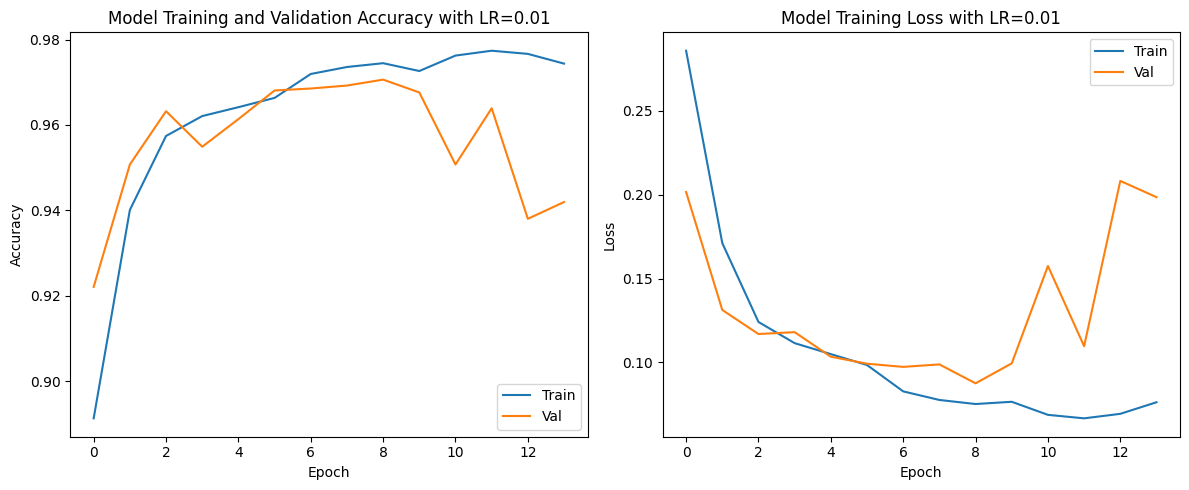

Training with learning rate: 0.001
Epoch 1/30
316/316 [==============================] - 4833s 15s/step - loss: 0.2975 - accuracy: 0.8815 - val_loss: 0.1805 - val_accuracy: 0.9383
Epoch 2/30
316/316 [==============================] - 4705s 15s/step - loss: 0.2073 - accuracy: 0.9274 - val_loss: 0.1548 - val_accuracy: 0.9489
Epoch 3/30
316/316 [==============================] - 4787s 15s/step - loss: 0.1411 - accuracy: 0.9523 - val_loss: 0.1366 - val_accuracy: 0.9544
Epoch 4/30
316/316 [==============================] - 4723s 15s/step - loss: 0.1042 - accuracy: 0.9649 - val_loss: 0.1059 - val_accuracy: 0.9655
Epoch 5/30
316/316 [==============================] - 4714s 15s/step - loss: 0.0883 - accuracy: 0.9703 - val_loss: 0.4748 - val_accuracy: 0.7634
Epoch 6/30
316/316 [==============================] - 4756s 15s/step - loss: 0.1565 - accuracy: 0.9428 - val_loss: 0.0825 - val_accuracy: 0.9734
Epoch 7/30
316/316 [==============================] - 4716s 15s/step - loss: 0.0908 - accuracy:

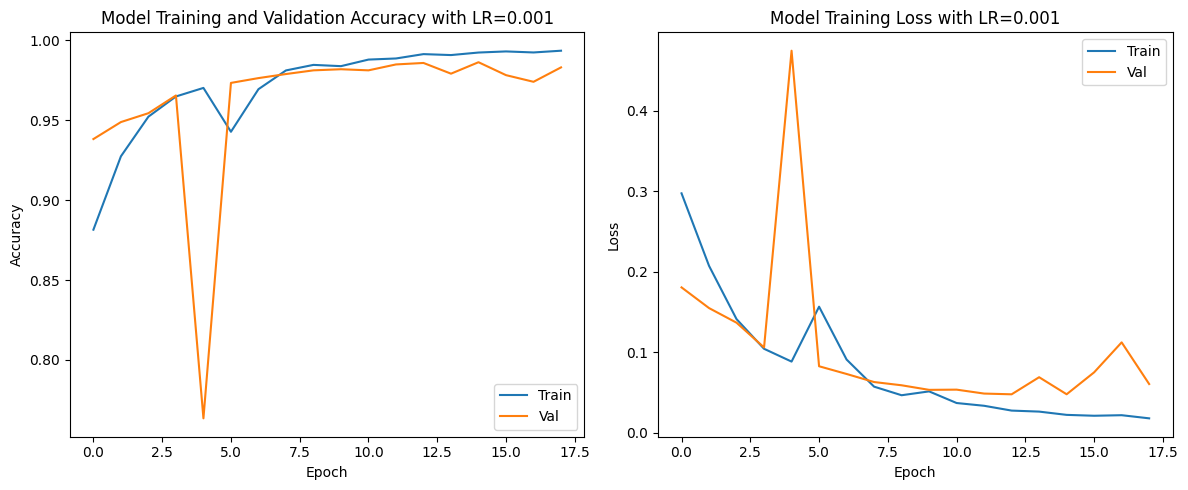

Training with learning rate: 0.0001
Epoch 1/30
316/316 [==============================] - 4862s 15s/step - loss: 0.3732 - accuracy: 0.8406 - val_loss: 0.3974 - val_accuracy: 0.8740
Epoch 2/30
316/316 [==============================] - 4824s 15s/step - loss: 0.2150 - accuracy: 0.9251 - val_loss: 0.2579 - val_accuracy: 0.9188
Epoch 3/30
316/316 [==============================] - 4558s 14s/step - loss: 0.1786 - accuracy: 0.9392 - val_loss: 0.2736 - val_accuracy: 0.9214
Epoch 4/30
316/316 [==============================] - 4576s 14s/step - loss: 0.1448 - accuracy: 0.9506 - val_loss: 0.1777 - val_accuracy: 0.9480
Epoch 5/30
316/316 [==============================] - 4663s 15s/step - loss: 0.1355 - accuracy: 0.9545 - val_loss: 0.2002 - val_accuracy: 0.9424
Epoch 6/30
316/316 [==============================] - 4683s 15s/step - loss: 0.1381 - accuracy: 0.9523 - val_loss: 0.1821 - val_accuracy: 0.9447
Epoch 7/30
316/316 [==============================] - 4692s 15s/step - loss: 0.1224 - accuracy

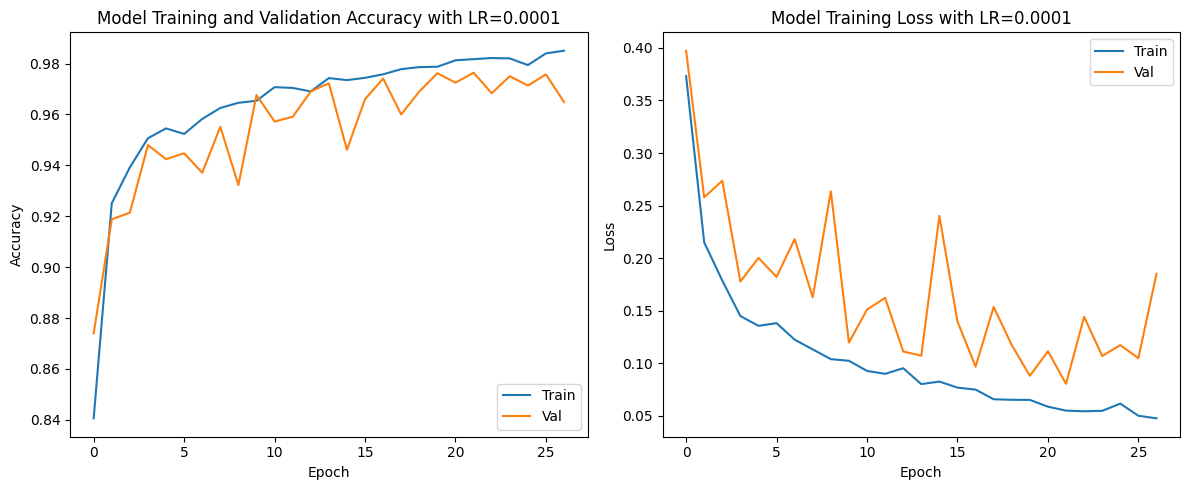

In [154]:
#Experimenting with learning rate of 0.1,0.001,0.0001
def create_model(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.3,recurrent_initializer='glorot_uniform')))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

def plot_history(history,lr):
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Training and Validation Accuracy with LR={lr}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='lower right')
    
    #Plot of training and validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Training Loss with LR={lr}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper right')
    plt.tight_layout()
    plt.show()

learning_rates =[0.01,0.001,0.0001]
histories = []
models =[]
for lr in learning_rates:
    model = create_model(embedding_layer)
    model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=lr), metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    print(f"Training with learning rate: {lr}")
    history = model.fit(x_train_padded,y_train,batch_size=64,epochs=30,validation_data=(x_val_padded,y_val),callbacks=[early_stop])
    histories.append(history)
    model_save_path = f"model_lr_{str(lr).replace('.','_')}.h5"
    model.save(model_save_path)
    print(f"Model with LR={lr} saved to {model_save_path}")
    plot_history(history,lr)

In [155]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [163]:
model_0_01= tf.keras.models.load_model('model_lr_0_01.h5')
model_0_001= tf.keras.models.load_model("model_lr_0_001.h5")
model_0_0001= tf.keras.models.load_model('model_lr_0_0001.h5')

def plot_confusion_matrix_report(model,x_test_padded,y_test,lr,embedding_name):
    y_pred = model.predict(x_test_padded)
    y_pred_binary = np.round(y_pred)
    y_test_binary = np.round(y_test)

    #Classification report
    report = classification_report(y_test_binary,y_pred_binary)
    print(f"Classification Report for {embedding_name} when Learning rate is {lr}:\n", report)
    #confusion matrix
    confusionMatrix = confusion_matrix(y_test_binary,y_pred_binary)
    plt.figure(figsize=(8,6))
    sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Blues",cbar=False, xticklabels=['Predicted 0','Predicted 1'],
               yticklabels=['Actual 0','Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {embedding_name} when learning rate is {lr}')
    plt.show()

136/136 [==============================] - 76s 558ms/step
Classification Report for Glove Embedding when Learning rate is 0.01:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2142
           1       0.98      0.96      0.97      2183

    accuracy                           0.97      4325
   macro avg       0.97      0.97      0.97      4325
weighted avg       0.97      0.97      0.97      4325



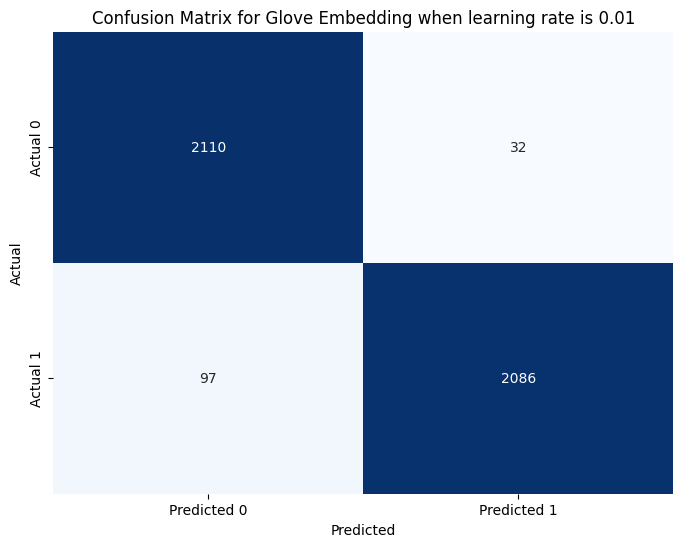

In [181]:
#Plot when learning rate is 0.01
plot_confusion_matrix_report(model_0_01,x_test_padded,y_test,0.01,'Glove Embedding')

136/136 [==============================] - 77s 564ms/step
Classification Report for Glove Embedding when Learning rate is 0.001:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2142
           1       0.99      0.98      0.99      2183

    accuracy                           0.99      4325
   macro avg       0.99      0.99      0.99      4325
weighted avg       0.99      0.99      0.99      4325



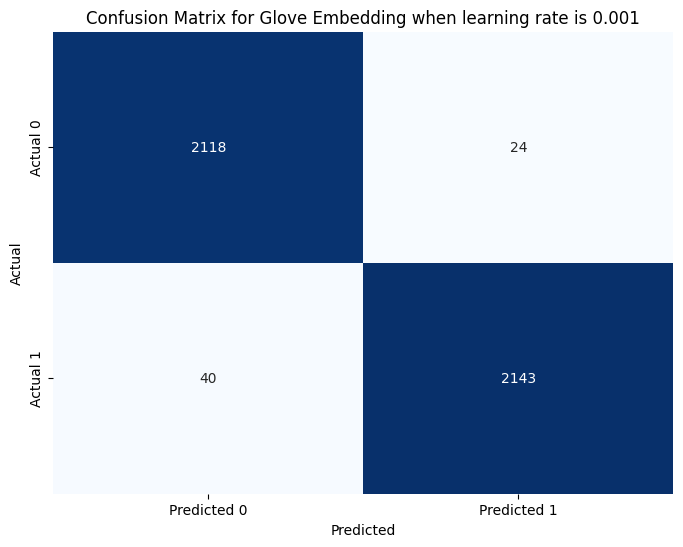

In [182]:
#Plot when learning rate is 0.001
plot_confusion_matrix_report(model_0_001,x_test_padded,y_test,0.001,'Glove Embedding')

136/136 [==============================] - 76s 560ms/step
Classification Report for Glove Embedding when Learning rate is 0.0001:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      2142
           1       0.97      0.99      0.98      2183

    accuracy                           0.98      4325
   macro avg       0.98      0.98      0.98      4325
weighted avg       0.98      0.98      0.98      4325



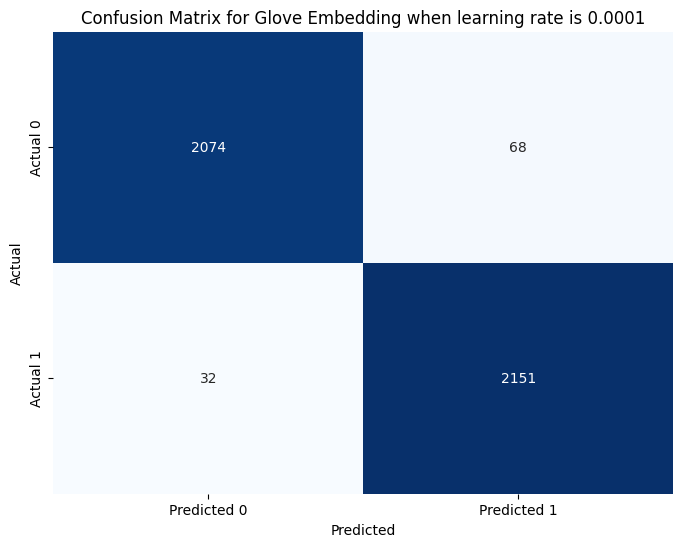

In [183]:
#Plot when learning rate is 0.0001
plot_confusion_matrix_report(model_0_0001,x_test_padded,y_test,0.0001,'Glove Embedding')

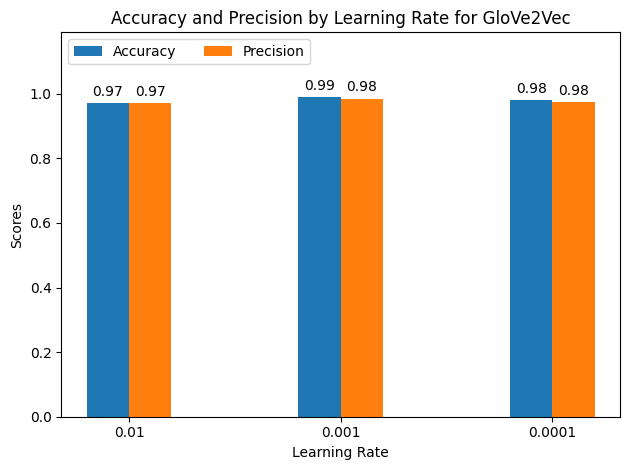

In [180]:
#Plot showing accuracy and precision bar for each learning rate
import matplotlib.pyplot as plt
import numpy as np

# Accuracy and precision values extracted from the classification reports
accuracy_precision = {
    "0.01": {"accuracy": 0.97, "precision": (0.96 + 0.98) / 2},
    "0.001": {"accuracy": 0.99, "precision": (0.98 + 0.99) / 2},
    "0.0001": {"accuracy": 0.98, "precision": (0.98 + 0.97) / 2}
}

# Preparing data for plotting
labels = list(accuracy_precision.keys())
accuracy_values = [accuracy_precision[lr]["accuracy"] for lr in labels]
precision_values = [accuracy_precision[lr]["precision"] for lr in labels]
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, precision_values, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Precision by Learning Rate for GloVeVec')
ax.set_xticks(x)
ax.legend(loc='upper left',ncols= 2)
current_top = max(max(accuracy_values),max(precision_values))
ax.set_ylim([0,current_top + 0.2])
ax.set_xticklabels(labels)


# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [89]:
for history in histories:
    print(history.history['accuracy'])

[0.9032162427902222, 0.953813374042511, 0.9224936962127686, 0.9482630491256714, 0.9477674961090088, 0.9513850808143616]


## Using Word2Vec Embedding

In [184]:
from gensim.models import KeyedVectors

In [185]:
google_wv = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin',binary=True)

In [186]:
word2vec_embedding = np.zeros((len(word_index)+1,300))

In [187]:
skipped_words = 0
for word,index in tokenizer.word_index.items():
    vector = None
    try:
        vector = google_wv.get_vector(word)
    except:
        skipped_words = skipped_words+1
        pass
    if vector is not None:
        word2vec_embedding[index]= vector
    else:
        pass

In [188]:
print(f'Total number of skipped words are:{skipped_words}')

Total number of skipped words are:25527


In [189]:
word2vec_embedding_layer = Embedding(len(word_index)+1,
                                    300,
                                    weights=[word2vec_embedding],
                                    input_length=max_length,
                                    trainable=False)

Training with learning rate: 0.01
Epoch 1/30
316/316 [==============================] - 4766s 15s/step - loss: 0.3670 - accuracy: 0.8396 - val_loss: 0.1849 - val_accuracy: 0.9341
Epoch 2/30
316/316 [==============================] - 4703s 15s/step - loss: 0.1683 - accuracy: 0.9429 - val_loss: 0.1061 - val_accuracy: 0.9648
Epoch 3/30
316/316 [==============================] - 4702s 15s/step - loss: 0.2256 - accuracy: 0.9176 - val_loss: 0.1785 - val_accuracy: 0.9417
Epoch 4/30
316/316 [==============================] - 4759s 15s/step - loss: 0.1527 - accuracy: 0.9493 - val_loss: 0.1675 - val_accuracy: 0.9494
Epoch 5/30
316/316 [==============================] - 4777s 15s/step - loss: 0.1134 - accuracy: 0.9616 - val_loss: 0.0999 - val_accuracy: 0.9685
Epoch 6/30
316/316 [==============================] - 4767s 15s/step - loss: 0.0911 - accuracy: 0.9693 - val_loss: 0.0948 - val_accuracy: 0.9688
Epoch 7/30
316/316 [==============================] - 4715s 15s/step - loss: 0.0862 - accuracy: 

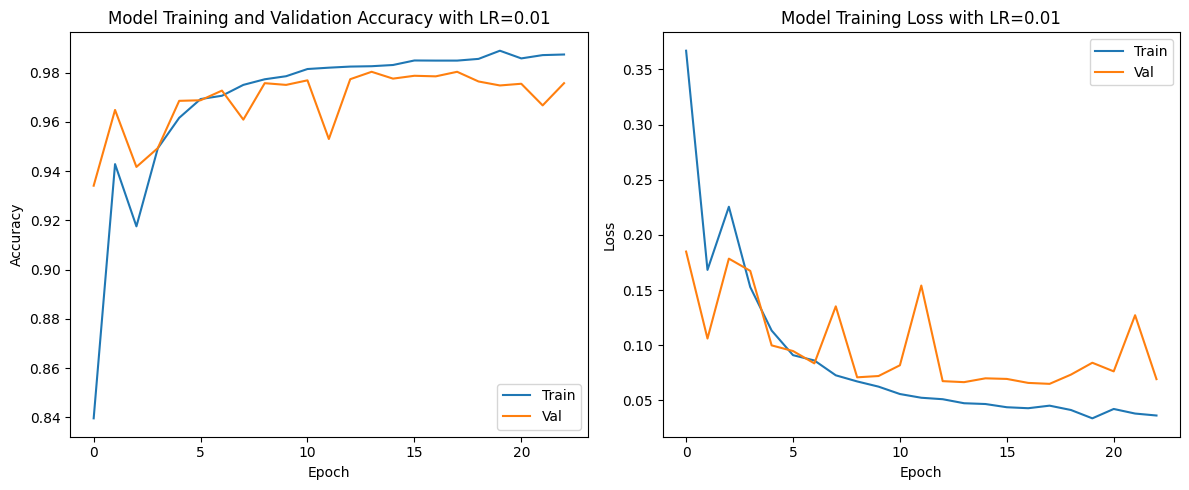

Training with learning rate: 0.001
Epoch 1/30
316/316 [==============================] - 4695s 15s/step - loss: 0.4373 - accuracy: 0.8131 - val_loss: 0.1977 - val_accuracy: 0.9350
Epoch 2/30
316/316 [==============================] - 4613s 15s/step - loss: 0.2234 - accuracy: 0.9219 - val_loss: 0.1603 - val_accuracy: 0.9484
Epoch 3/30
316/316 [==============================] - 4571s 14s/step - loss: 0.2192 - accuracy: 0.9245 - val_loss: 0.2145 - val_accuracy: 0.9336
Epoch 4/30
316/316 [==============================] - 4634s 15s/step - loss: 0.3931 - accuracy: 0.8269 - val_loss: 0.4011 - val_accuracy: 0.8173
Epoch 5/30
316/316 [==============================] - 4569s 14s/step - loss: 0.2396 - accuracy: 0.9108 - val_loss: 0.1256 - val_accuracy: 0.9607
Epoch 6/30
316/316 [==============================] - 4542s 14s/step - loss: 0.1795 - accuracy: 0.9353 - val_loss: 0.1301 - val_accuracy: 0.9600
Epoch 7/30
316/316 [==============================] - 4571s 14s/step - loss: 0.1882 - accuracy:

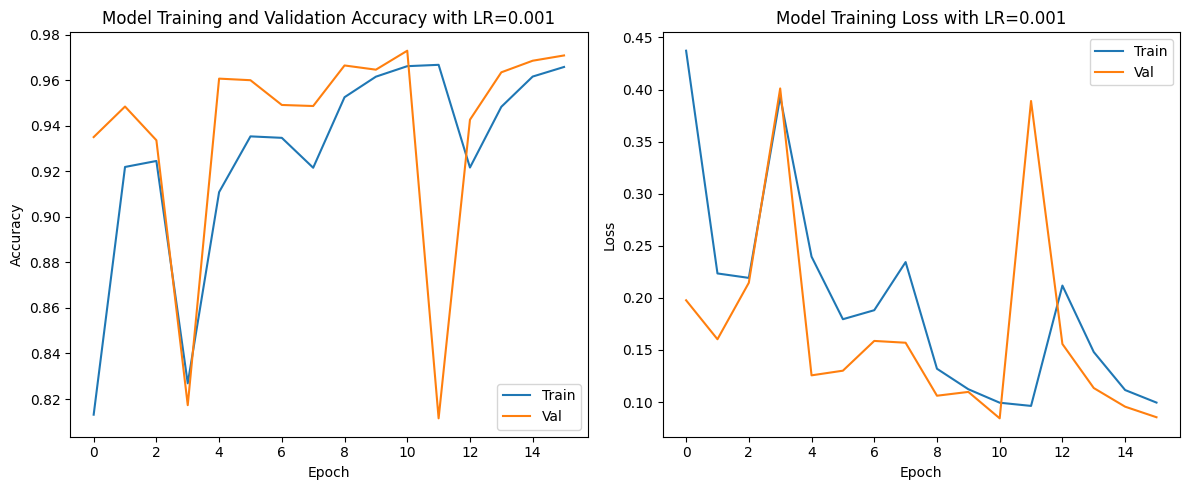

Training with learning rate: 0.0001
Epoch 1/30
316/316 [==============================] - 4726s 15s/step - loss: 0.3850 - accuracy: 0.8376 - val_loss: 0.2726 - val_accuracy: 0.9170
Epoch 2/30
316/316 [==============================] - 4764s 15s/step - loss: 0.2138 - accuracy: 0.9325 - val_loss: 0.2661 - val_accuracy: 0.9223
Epoch 3/30
316/316 [==============================] - 4805s 15s/step - loss: 0.2655 - accuracy: 0.8954 - val_loss: 0.4735 - val_accuracy: 0.8689
Epoch 4/30
316/316 [==============================] - 4732s 15s/step - loss: 0.2407 - accuracy: 0.9244 - val_loss: 0.1551 - val_accuracy: 0.9542
Epoch 5/30
316/316 [==============================] - 4671s 15s/step - loss: 0.1536 - accuracy: 0.9483 - val_loss: 0.1214 - val_accuracy: 0.9625
Epoch 6/30
316/316 [==============================] - 4743s 15s/step - loss: 0.1433 - accuracy: 0.9521 - val_loss: 0.1205 - val_accuracy: 0.9621
Epoch 7/30
316/316 [==============================] - 4721s 15s/step - loss: 0.1279 - accuracy

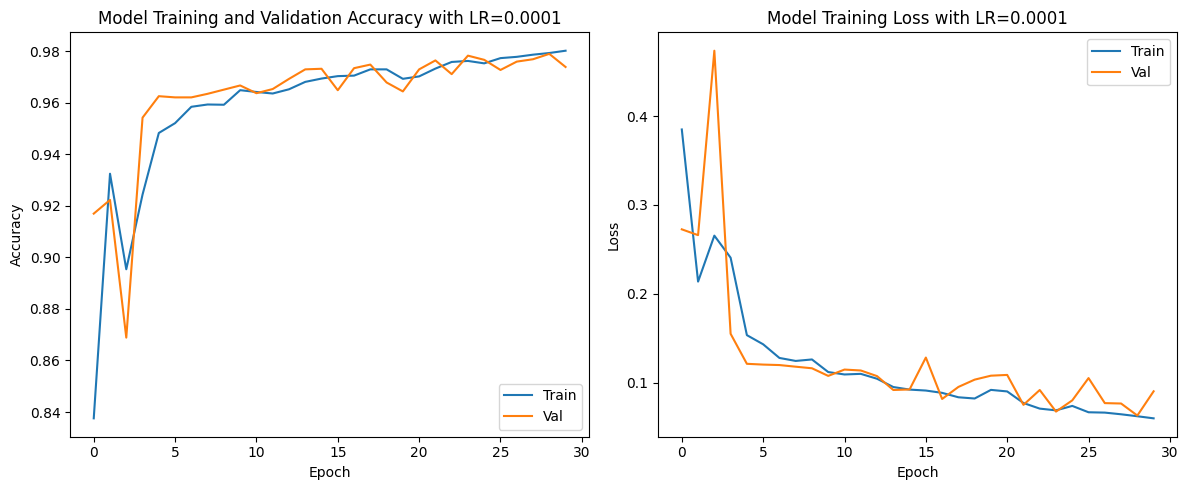

In [190]:
learning_rates =[0.01,0.001,0.0001]
histories_word2Vec = []
models =[]
for lr in learning_rates:
    model = create_model(word2vec_embedding_layer)
    model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate=lr), metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    print(f"Training with learning rate: {lr}")
    history = model.fit(x_train_padded,y_train,batch_size=64,epochs=30,validation_data=(x_val_padded,y_val),callbacks=[early_stop])
    histories_word2Vec.append(history)
    model_save_path = f"word2vec_model_lr_{str(lr).replace('.','_')}.h5"
    model.save(model_save_path)
    print(f"Model with LR={lr} saved to {model_save_path}")
    plot_history(history,lr)

In [ ]:
## Read on LIME for model interpretability.
# LIME could identifies which features influence the model
# to reach certain conclusion by removing or altering the tokens
# within smart contract

In [191]:
word2vec_model_0_01= tf.keras.models.load_model('word2vec_model_lr_0_01.h5')
word2vec_model_0_001= tf.keras.models.load_model("word2vec_model_lr_0_001.h5")
word2vec_model_0_0001= tf.keras.models.load_model('word2vec_model_lr_0_0001.h5')

136/136 [==============================] - 77s 560ms/step
Classification Report for Word2Vec Embedding when Learning rate is 0.01:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2142
           1       0.98      0.98      0.98      2183

    accuracy                           0.98      4325
   macro avg       0.98      0.98      0.98      4325
weighted avg       0.98      0.98      0.98      4325



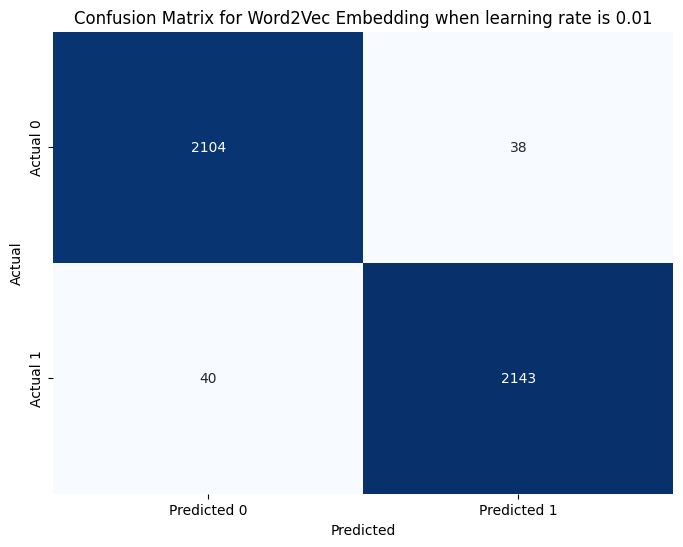

In [192]:
#Plot when learning rate is 0.01
plot_confusion_matrix_report(word2vec_model_0_01,x_test_padded,y_test,0.01,'Word2Vec Embedding')

136/136 [==============================] - 77s 563ms/step
Classification Report for Word2Vec Embedding when Learning rate is 0.001:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2142
           1       0.98      0.96      0.97      2183

    accuracy                           0.97      4325
   macro avg       0.97      0.97      0.97      4325
weighted avg       0.97      0.97      0.97      4325



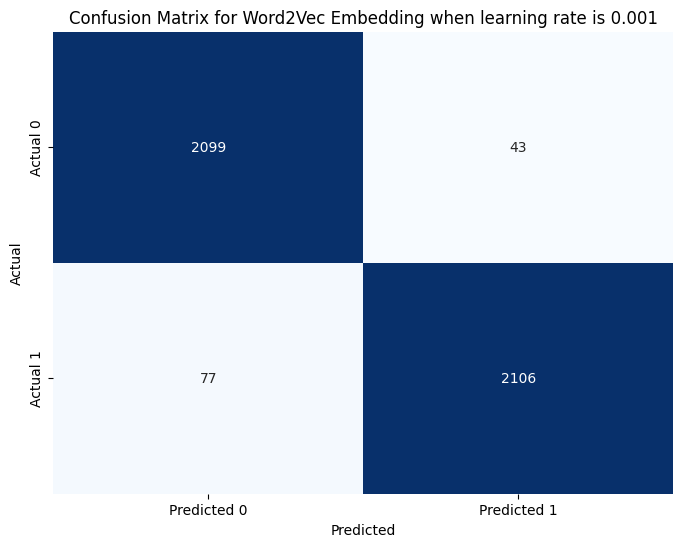

In [193]:
#Plot when learning rate is 0.001
plot_confusion_matrix_report(word2vec_model_0_001,x_test_padded,y_test,0.001,'Word2Vec Embedding')

136/136 [==============================] - 77s 561ms/step
Classification Report for Word2Vec Embedding when Learning rate is 0.0001:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2142
           1       0.98      0.98      0.98      2183

    accuracy                           0.98      4325
   macro avg       0.98      0.98      0.98      4325
weighted avg       0.98      0.98      0.98      4325



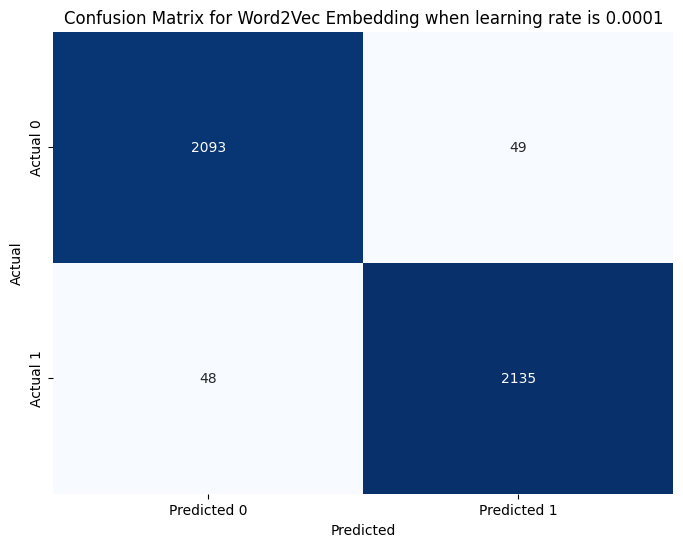

In [194]:
#Plot when learning rate is 0.0001
plot_confusion_matrix_report(word2vec_model_0_0001,x_test_padded,y_test,0.0001,'Word2Vec Embedding')

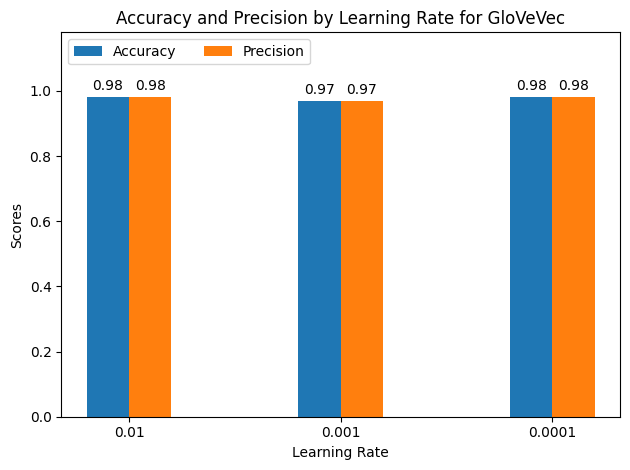

In [195]:
# Accuracy and precision values extracted from the classification reports
accuracy_precision = {
    "0.01": {"accuracy": 0.98, "precision": 0.98},
    "0.001": {"accuracy": 0.97, "precision": 0.97},
    "0.0001": {"accuracy": 0.98, "precision": 0.98}
}

# Preparing data for plotting
labels = list(accuracy_precision.keys())
accuracy_values = [accuracy_precision[lr]["accuracy"] for lr in labels]
precision_values = [accuracy_precision[lr]["precision"] for lr in labels]
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, precision_values, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Precision by Learning Rate for GloVeVec')
ax.set_xticks(x)
ax.legend(loc='upper left',ncols= 2)
current_top = max(max(accuracy_values),max(precision_values))
ax.set_ylim([0,current_top + 0.2])
ax.set_xticklabels(labels)


# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()